The following is a logistic regression approach to trade data supplied by Jane Street in a Kaggle Machine Learning competition: https://www.kaggle.com/c/jane-street-market-prediction
There are 130 anonymized, normalized features for each row of data respresenting possible trades. The return over various time horizons is also supplied, as well as weights for each trade. Using machine learning, the aim is to create an online version of an algorithm created with the test data. 
Due to the immense size of the dataset, I will be using kdb in my exploratory analysis and model selection/fitting.

In [1]:
\c 100 100
\cd C:\q\w32\

/ Import Python libraries
\l p.q
/import several ml libraries
\l quantQ\lib\quantQjupyterq.q
\l mlnotebooks\utils\graphics.q
\l automl\automl.q


\l ml\ml.q

\l mlnotebooks\utils\graphics.q
\l mlnotebooks\utils\util.q
/Fun Q ml library
\l funq\funqJQ.q
/graphing 
\l embedPy\examples\importmatplotlib.q
plt:.matplotlib.pyplot[]



Welcome to quantQ
   ____ \ \   
  / ___| \ \  
 | |_| |  ) )   
  \__  | / /   
     |_|/ /     

For available sub-namespaces, type key`.quantQ:
()

For functions in a namespace, type .e.g \f .quantQ.rf



In [2]:
//A True/false table is given for our 130 features
features:("SSSSSSSSSSSSSSSSSSSSSSSSSSSSSS";enlist",") 0: `:C:/MLProjects/JaneStreetMarketPrediction/features.csv
features:(select feature from features) ,'(flip 1_flip features = `TRUE)
`feature xkey `features 
features:"f"$features
show 10#features

//1 for true, 0 for false

`features


feature  | tag_0 tag_1 tag_2 tag_3 tag_4 tag_5 tag_6 tag_7 tag_8 tag_9 tag_10 tag_11 tag_12 tag_1..
---------| --------------------------------------------------------------------------------------..
feature_0| 0     0     0     0     0     0     0     0     0     0     0      0      0      0    ..
feature_1| 0     0     0     0     0     0     1     1     0     0     0      0      0      0    ..
feature_2| 0     0     0     0     0     0     1     1     0     1     0      0      0      0    ..
feature_3| 0     0     0     0     0     0     1     0     1     0     0      0      0      0    ..
feature_4| 0     0     0     0     0     0     1     0     1     1     0      0      0      0    ..
feature_5| 0     0     0     0     0     0     1     0     0     0     1      0      0      0    ..
feature_6| 0     0     0     0     0     0     1     0     0     1     1      0      0      0    ..
feature_7| 0     0     0     0     1     0     1     0     0     0     0      1      0      0    ..


In [3]:
//load 500 days of trade data
t:("FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF";enlist",") 0: `:C:/MLProjects/JaneStreetMarketPrediction/train.csv

In [4]:
//key the table based on date
`date xkey `t
//apply sort attribute on table t
`s#t;

`t


In [5]:
count select from t where resp_4 >0, resp<0
count select from t where resp_4 >0, resp>0

count select from t where resp_4 <0, resp<0
count select from t where resp_4 <0, resp>0

111694


1093808


1073823


111166


In [6]:
/
There is a high likelihood of

Rule 1: Optimize for resp_4
Rule 2: Don't take trades with weight above X
Rule 3: End model uses online learning
Rule 4: Be prepared for regime change (Identify the change itself, warning signs, and effects)
Rule 5: Feature Engineer lagging indicators

`t


{[f;x]embedPy[f;x]}[foreign]enlist


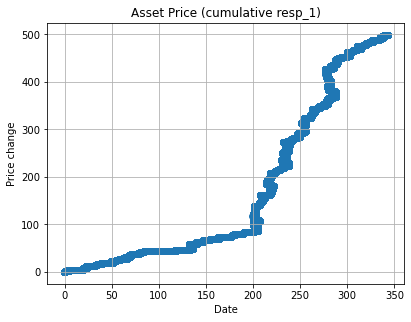

In [7]:
update sumresp:sums resp_1 from `t
plt.xlabel"Date";
plt.ylabel"Price change";
plt.title"Asset Price (cumulative resp_1)";
plt.grid 1b;
plt.scatter[exec sumresp from t;  exec date from t]
plt.show[];

In [8]:
//we see the asset appreciate over time, making most trades profitable
//we will likely see very similar trading days. We will try to cluster trading days together later on
delete sumresp from `t;

In [9]:
//We analyze the data on a per day basis. 

day0t:select from t where date=0
day0t:0!day0t //unkey
delete date, weight, ts_id  from `day0t;
update trade:0 from `day0t;
update trade: 1 from `day0t where  resp>0;
day0t:`trade xcols day0t

In [10]:
//Partition data into training and testing, no time series data leakage
d:.ut.part[`train`test!3 1;til] "f"$day0t
//fill nulls
d.train:0f^d.train
d.test:0f^d.test
delete resp_1, resp_2, resp_3, resp_4, resp from `d.train
delete resp_1, resp_2, resp_3, resp_4, resp from `d.test

`d.train


`d.test


In [11]:
y:first get first `Y`X set' 0 1 cut value flip d`train
yt:first get first `Yt`Xt set' 0 1 cut value flip d`test



In [12]:
zsf:.ml.zscoref each X
X:zsf @' X
Xt:zsf @' Xt

In [13]:
//unregularized
show THETA:enlist theta:(1+count X)#0f
THETA:1#.fmincg.fmincg[2000;.ml.logcostgrad[();Y;X];THETA 0]
avg yt=first "i"$.ml.plog[Xt] THETA

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0..
Iteration 2000 | cost: 0.6199943


0.6392269


In [14]:
//We will now regularize
f:.ml.logcost[();Yt;Xt]1#.fmincg.fmincg[;;THETA 0]::
l2:.ut.sseq[.05;0;.55]
e:(f[1000] .ml.logcostgrad[;Y;X] .ml.l2@) each l2

Iteration 1000 | cost: 0.6199939
Iteration 1000 | cost: 0.6205895
Iteration 1000 | cost: 0.6211261
Iteration 1000 | cost: 0.6216119
Iteration 1000 | cost: 0.6220583
Iteration 1000 | cost: 0.6224699
Iteration 1000 | cost: 0.6228538
Iteration 1000 | cost: 0.6232106
Iteration 1000 | cost: 0.623546
Iteration 1000 | cost: 0.6238618
Iteration 1000 | cost: 0.6241602
Iteration 1000 | cost: 0.6244429


In [15]:
//Find optimal l2 regularization
.ml.imin l2!e

0.55


In [52]:
//0.55 is the optimal l2 regularization parameter
THETA:1#.fmincg.fmincg[1000;.ml.logcostgrad[.ml.l2[0.55];Y;X]; THETA 0]

Iteration 1000 | cost: 0.6905161


In [53]:
.ut.rnd[0.01] p0:first .ml.plog[Xt] THETA

0.52 0.5 0.51 0.52 0.51 0.53 0.49 0.5 0.56 0.49 0.48 0.53 0.49 0.52 0.53 0.49 0.52 0.5 0.54 0.52 ..


In [54]:
"i"$p0
avg yt="i"$p0

1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1..


0.5375805


In [55]:
// 53.75% accuracy on test data is not good. 
testTable0:1397#t
update test0:p0>0.5 from `testTable0
select avg resp from testTable0 where test0=1

`testTable0


resp          
--------------
-6.629976e-005


In [56]:
select avg resp from testTable0
select avg resp from testTable0 where test0=0
(exec avg resp from testTable0 where test0=0)%(exec avg resp from testTable0)

resp        
------------
0.0003523198


resp       
-----------
0.001306497


3.708271


In [57]:
//A 270% increase in return over random selection is great, though we have to reverse the intent of the algo
//Instead of predicting trades using features, we will use the change in features
delta0t:day0t - prev day0t
delta0:0f^delta0t
update trade:(exec trade from day0t) from `delta0t
delta0t:1_delta0t; //drop first row
delta0:.ut.part[`train`test!3 1;til] "f"$delta0t
delete resp_1, resp_2, resp_3, resp_4, resp from `delta0.train;
delete resp_1, resp_2, resp_3, resp_4, resp from `delta0.test;
delta0.train:0f^delta0.train
delta0.test:0f^delta0.test

`delta0t


In [58]:
y:first get first `Y`X set' 0 1 cut value flip delta0.train
yt:first get first `Yt`Xt set' 0 1 cut value flip delta0.test

zsf:.ml.zscoref each X
X:zsf @' X
Xt:zsf @' Xt

In [59]:
show THETA:enlist theta:(1+count X)#0f
f:.ml.logcost[();Yt;Xt]1#.fmincg.fmincg[;;THETA 0]::
l2:.ut.sseq[.05;0;.55]
e:(f[1000] .ml.logcostgrad[;Y;X] .ml.l2@) each l2

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0..
Iteration 1000 | cost: 0.6543637
Iteration 1000 | cost: 0.6546062
Iteration 1000 | cost: 0.6548315
Iteration 1000 | cost: 0.6550414
Iteration 1000 | cost: 0.6552398
Iteration 1000 | cost: 0.6554231
Iteration 1000 | cost: 0.6555968
Iteration 1000 | cost: 0.6557618
Iteration 1000 | cost: 0.6559181
Iteration 1000 | cost: 0.6560667
Iteration 1000 | cost: 0.6562088
Iteration 1000 | cost: 0.6563445


In [60]:
//Find optimal l2 regularization
show l2reg:.ml.imin l2!e

0.55


In [61]:
//0.55 is still the optimal l2 regularization parameter
THETA:1#.fmincg.fmincg[1000;.ml.logcostgrad[.ml.l2[l2reg];Y;X]; THETA 0]
.ut.rnd[0.01] p:first .ml.plog[Xt] THETA
"i"$p
avg yt="i"$p

Iteration 1000 | cost: 0.6563445


0.55 0.62 0.32 0.6 0.44 0.67 0.38 0.78 0.42 0.38 0.66 0.26 0.56 0.5 0.48 0.58 0.38 0.53 0.5 0.59 ..


1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1..


0.6012885


In [62]:
//60% accuracy is not a bad score as a trade selector
//We can still see if the predicted trades have 
p:0,p //replace initial row

In [63]:
count p>.5

1398


In [64]:
testTable:1398#t
update test:p>0.5 from `testTable

`testTable


In [65]:
select avg resp from testTable where test=1

resp         
-------------
-0.0005294266


In [66]:
select avg resp from testTable
select avg resp from testTable where test=0
(exec avg resp from testTable where test=0)%(exec avg resp from testTable)

resp        
------------
0.0003325124


resp       
-----------
0.001330127


4.000233


In [67]:
//Interestingly, when we inverse the intent of the algo we do quite well, 4x better in fact.
//selection via feature deltas is significantly better than using features
//Below is the  best possibl score
select avg resp from testTable where resp>0

resp     
---------
0.0185262


In [68]:
//These are just the THETAs for a single day. We make the assumption that each day has different trading dynamics
//We now must test our THETAs over a period of dates
//Perhaps there are similar trading days which we can cluster

In [69]:
//create day1t table
day1t:select from t where date=1
day1t:0!day1t //unkey
delete date, weight, ts_id  from `day1t;
update trade:0 from `day1t;
update trade: 1 from `day1t where  resp>0;
day1t:`trade xcols day1t

In [70]:
//create delta1t table
delta1t:day1t - prev day1t
update trade:(exec trade from day1t) from `delta1t
delta1t:1_delta1t; //drop first row
delta1:0f^delta1t
delete resp_1, resp_2, resp_3, resp_4, resp from `delta1;
delta1:0f^delta1


`delta1t


In [71]:
y:first get first `Y`X set' 0 1 cut value flip delta1
zsf:.ml.zscoref each X
X:zsf @' X



In [72]:
.ut.rnd[0.01] p1:first .ml.plog[X] THETA
"i"$p1
avg y="i"$p1

0.95 0.53 0.59 0.47 0.4 0.7 0.57 0.43 0.64 0.26 0.75 0.51 0.43 0.45 0.51 0.4 0.74 0.3 0.66 0.49 0..


1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1..


0.4474468


In [73]:
p1:0,p1 //replace initial row
count p1
count select from t where date=1

9401


9401


In [74]:
testTable1:select from t where date =1
update test:p1>0.5 from `testTable1

`testTable1


In [75]:
select avg resp from testTable1 where test=1

resp        
------------
-0.004425147


In [76]:
select avg resp from testTable1
select avg resp from testTable1 where test=0
abs((exec avg resp from testTable1 where test=0)%(exec avg resp from testTable1))

resp        
------------
-0.001195134


resp       
-----------
0.002487066


2.080993


In [77]:
//Even on a different day, we still have positive results (108% increase), though the THETAs likely would need to be adjusted.
//We can either find new THETAs across a larger set of dates and apply to the table, or find new THETAs every so often
//It is unlikely there is some static set of THETAs which will give us what we want, but it doesn't hurt to try

In [78]:
//We will start out by applying current THETAs to first 30 days to see how alpha deteriorates over time
/create table
t30:select from t where date<31
t30:0!t30 //unkey
delete date, weight, ts_id  from `t30;
update trade:0 from `t30;
update trade: 1 from `t30 where  resp>0;
t30:`trade xcols t30

/create delta table

delta30t:t30 - prev t30
update trade:(exec trade from t30) from `delta30t
delta30t:1_delta30t; //drop first row
delta30:0f^delta30t
delete resp_1, resp_2, resp_3, resp_4, resp from `delta30;
delta30:0f^delta30

y:first get first `Y`X set' 0 1 cut value flip delta30
zsf:.ml.zscoref each X
X:zsf @' X


`delta30t


In [79]:
.ut.rnd[0.01] p30:first .ml.plog[X] THETA
"i"$p30
avg y="i"$p30

0.36 0.6 0.47 0.61 0.37 0.51 0.55 0.61 0.52 0.44 0.59 0.45 0.45 0.62 0.45 0.6 0.46 0.41 0.65 0.39..


0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0..


0.5007792


In [80]:
p30:0,p30 //replace initial row
count p30
count select from t30 

197635


197635


In [81]:
update test:p30>0.5 from `t30

`t30


In [83]:
update date:(count t30)#(exec date from t) from `t30;

In [84]:
select avg resp by date from t30 where test=0

date| resp          
----| --------------
0   | -0.003912333  
1   | 0.002706875   
2   | 0.001135305   
3   | -4.366495e-005
4   | -0.0007514599 
5   | 0.006626119   
6   | 0.001959713   
7   | -0.002758925  
8   | -0.0007434203 
9   | 0.005426438   
10  | 0.002385821   
11  | -0.001534399  
12  | -0.0007477914 
13  | 0.001906472   
14  | -0.0007332412 
15  | 0.0001541447  
16  | -0.001930678  
17  | 0.003427274   
18  | 0.002756853   
19  | 0.006212003   
20  | -0.0001562282 
21  | -0.0008245328 
22  | -0.00259114   
23  | 5.918281e-005 
24  | -0.002901787  
25  | 0.00367755    
26  | -0.001332375  
27  | 0.00344361    
28  | 0.001423663   
29  | 0.007244302   
30  | -0.001174495  


Although we had positive initial results, we can see that re-using the THETAs over different trading days does not give consistent results. It is possible that different sets of THETAs for our logistic regression could yield positive results when used on certain "types" of trading days, which could be determined by various clustering methods, but a cluster analysis is beyond the scope of this notebook.